# Getting the Data

## Installing Dependencies

In [1]:
!pip install boto3
!pip install matplotlib
!pip install scipy
!pip install Pillow

## Import Dependencies

In [0]:
from dataclasses import dataclass
import itertools
import json
import multiprocessing
from pathlib import Path
import subprocess
from typing import Dict, List, Tuple

import boto3
from botocore import UNSIGNED
from botocore.client import Config
from matplotlib.pyplot import imshow
import PIL
from PIL import Image, ImageDraw
from scipy.io import loadmat

## Download SVHN Dataset

In [3]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2020-05-02 05:22:04--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  54.3MB/s    in 3.6s    

2020-05-02 05:22:08 (47.7 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2020-05-02 05:22:08--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  27.5MB/s    in 2.2s    

2020-05-02 05:22:10 (27.5 MB/s) - ‘test_32x32.mat’ saved [64275384/64

## Download COCO Dataset

In [4]:
# This code downloads the coco dataset from Amazon S3 in parallel.
files = ['val2017.zip', 'annotations_trainval2017.zip', 'train2017.zip']

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))


def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)


# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished downloading val2017.zip . Starting to unzip.
Finished unzipping annotations_trainval2017.zip
Finished unzipping val2017.zip
Finished downloading train2017.zip . Starting to unzip.
Finished unzipping train2017.zip
Done transferring all datasets


## Plotting SVHN Dataset

In [0]:
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

In [6]:
train['X'][0][0].shape

(3, 73257)

Digit Label: 5


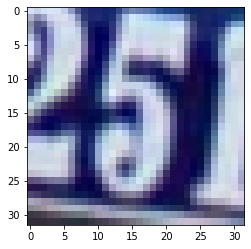

In [7]:
def show_label_and_image(i: int, split: Dict=train) -> None:
    # If the digit_label is 10, that means the actual label is zero.
    digit_label = split['y'][i].item()
    print(f"Digit Label: {digit_label if digit_label != 10 else 0}")
    imshow(split['X'][:,:,:, i])

show_label_and_image(88, split=train)

## Plotting COCO Keypoint Dataset

In [0]:
j = json.load(open("annotations/person_keypoints_train2017.json", "r"))

In [9]:
img_path = next(itertools.islice(Path("train2017").glob("*"), 28, None))
print(img_path)

IMAGE_ID = 363386
IMAGE_ID in [x["image_id"] for x in j["annotations"]]

train2017/000000363386.jpg


True

Convert the bounding box to an actual python object for easier manipulation.

In [0]:
@dataclass(frozen=True)
class BoundingBox:
    """An object that describes a box within an image which contains a region
    of interest.
    """
    x: float
    y: float
    width: float
    height: float

    def to_xy_list(self) -> List[float]:
        """Takes a BoundingBox object and return a list of
        [x1, y1, x2, y2, x3, y3, x4, y4, x1, y1] suitable for use by the PIL
        ImageDraw.line function. Note the bounding box is drawn from the
        starting coordinate clock-wise.
        """
        return [self.x, self.y, self.x + self.width, self.y, self.x + self.width, self.y + self.height, self.x, self.y + self.height, self.x, self.y]
    
    def to_crop_coords(self) -> Tuple[float, float, float, float]:
        """Takes a BoundingBox object and returns a tuple that is suitable for
        use with the PIL.Image.crop and PIL.Image.resize methods. These methods
        expects crop coodinates to be: (left, upper, right, lower)
        """
        return (self.x, self.y, self.x + self.width, self.y + self.height)


bbox_list = [x for x in j["annotations"] if x["image_id"] == IMAGE_ID][0]['bbox']
bbox = BoundingBox(*bbox_list)

Convert the keypoints to actual python objects for easier manipulation.

In [11]:
keypoint_names = j["categories"][0]["keypoints"]
keypoint_names

['nose',
 'left_eye',
 'right_eye',
 'left_ear',
 'right_ear',
 'left_shoulder',
 'right_shoulder',
 'left_elbow',
 'right_elbow',
 'left_wrist',
 'right_wrist',
 'left_hip',
 'right_hip',
 'left_knee',
 'right_knee',
 'left_ankle',
 'right_ankle']

In [0]:
keypoint_list = [x for x in j["annotations"] if x["image_id"] == IMAGE_ID][0]["keypoints"]

In [0]:
keypoint_tuples = list(zip(keypoint_names, [keypoint_list[i:i + 3] for i in range(0, len(keypoint_list), 3)]))

In [14]:
@dataclass(frozen=True)
class KeyPoint:
    """An object that represents a keypoint. Note that the coordinates of the
    keypoint are relative to the original annotated image and may need to be
    transformed if it is to be plotted on a transformed image.
    """
    x: int
    y: int
    label: str
    visibility: int


keypoints = [KeyPoint(x=i[1][0], y=i[1][1], label=i[0], visibility=i[1][2]) for i in keypoint_tuples]
keypoints

[KeyPoint(x=329, y=88, label='nose', visibility=2),
 KeyPoint(x=337, y=82, label='left_eye', visibility=2),
 KeyPoint(x=324, y=81, label='right_eye', visibility=2),
 KeyPoint(x=356, y=89, label='left_ear', visibility=2),
 KeyPoint(x=0, y=0, label='right_ear', visibility=0),
 KeyPoint(x=374, y=123, label='left_shoulder', visibility=2),
 KeyPoint(x=311, y=125, label='right_shoulder', visibility=2),
 KeyPoint(x=390, y=175, label='left_elbow', visibility=2),
 KeyPoint(x=274, y=188, label='right_elbow', visibility=2),
 KeyPoint(x=413, y=226, label='left_wrist', visibility=2),
 KeyPoint(x=240, y=232, label='right_wrist', visibility=2),
 KeyPoint(x=356, y=253, label='left_hip', visibility=2),
 KeyPoint(x=311, y=256, label='right_hip', visibility=2),
 KeyPoint(x=341, y=335, label='left_knee', visibility=2),
 KeyPoint(x=298, y=336, label='right_knee', visibility=2),
 KeyPoint(x=325, y=421, label='left_ankle', visibility=1),
 KeyPoint(x=297, y=373, label='right_ankle', visibility=2)]

Plot the original image with bounding box and keypoint annotations.

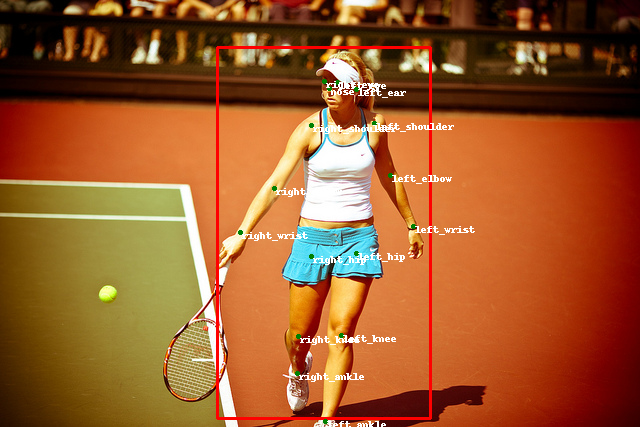

In [15]:
@dataclass(frozen=True)
class Box:
    """An object that contains a width and a height. Can be used to represent
    the size of a resized image.
    """
    width: int
    height: int


def draw_bbox(draw: PIL.ImageDraw.ImageDraw, bbox: BoundingBox, width: int=3) -> None:
    draw.line(bbox.to_xy_list(), fill="red", width=width)

def draw_keypoint(draw: PIL.ImageDraw.ImageDraw, key_point: KeyPoint, bbox: BoundingBox=None, resized: Box=None, radius: int=1) -> None:
    if key_point.visibility != 0:
        x_scale = 1 if resized is None else resized.width/bbox.width
        y_scale = 1 if resized is None else resized.height/bbox.height
        x_origin, y_origin = (0, 0) if bbox is None else (bbox.x, bbox.y)
        draw.ellipse([(key_point.x - x_origin) * x_scale - radius,
                      (key_point.y - y_origin) * y_scale - radius,
                      (key_point.x - x_origin) * x_scale + radius,
                      (key_point.y - y_origin) * y_scale + radius], fill="green")
        draw.text([(key_point.x - x_origin) * x_scale + radius,
                   (key_point.y - y_origin) * y_scale - radius], key_point.label)
    else:
        pass

def annotate_image(img_path: Path, bbox: BoundingBox, keypoints: List[KeyPoint]) -> PIL.Image.Image:
    with Image.open(img_path, "r") as im:
        draw = ImageDraw.Draw(im)

    draw_bbox(draw, bbox=bbox)
    for kp in keypoints:
        draw_keypoint(draw, key_point=kp, radius=2)
    return im

annotate_image(img_path, bbox, keypoints)

### Resize Image to Bounding Box

Crop the image inside the bounding box and then resize the cropped image to a size of 192-width by 256-height pixels. Then plot the skeleton or the keypoints on the resized image.


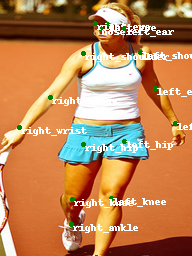

In [16]:
def crop_resize_and_annotate_image(img_path: Path, bbox: BoundingBox, keypoints: List[KeyPoint], new_size: Box) -> PIL.Image.Image:
    with Image.open(img_path, "r") as im:
        im_crop = im.resize(size=(new_size.width, new_size.height), box=bbox.to_crop_coords())
        draw = ImageDraw.Draw(im_crop)
        for kp in keypoints:
            draw_keypoint(draw, key_point=kp, bbox=bbox, resized=new_size, radius=2)
    return im_crop

crop_resize_and_annotate_image(img_path, bbox=bbox, keypoints=keypoints, new_size=Box(width=192, height=256))